In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# **Import Required Libraries**

In [2]:
!pip install -U scikit-learn==0.24.1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist.axislines import Subplot
from matplotlib.dates import num2date
from matplotlib.ticker import Formatter
from copy import copy, deepcopy
import pytz
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.stats import boxcox
from pickle import dump, load
from datetime import datetime

import tensorflow as tf
from tensorflow import GradientTape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.metrics import RootMeanSquaredError, Mean
from tensorflow.keras.layers import Input, Dense, LSTM, Layer, Bidirectional, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.losses import huber, mse, Loss, Reduction
import tensorflow.keras.backend as K

Requirement already up-to-date: scikit-learn==0.24.1 in /usr/local/lib/python3.7/dist-packages (0.24.1)


# **Import Data**

In [3]:
trainX = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/trainXReadings.pkl', 'rb'))
trainY = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/trainYReadings.pkl', 'rb'))
testX = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/testXReadings.pkl', 'rb'))
testY = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/testYReadings.pkl', 'rb'))

officeNumberTrain = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/officeNumberTrain.pkl', 'rb'))
officeNumberTest = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/officeNumberTest.pkl', 'rb'))

dateTrainX = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/dateTrainX.pkl', 'rb'))
dateTrainY = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/dateTrainY.pkl', 'rb'))
dateTestX = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/dateTestX.pkl', 'rb'))
dateTestY = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/dateTestY.pkl', 'rb'))

scaler = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/scaler.pkl', 'rb'))

print(len(trainX), len(trainY))
print(trainX[0].shape, trainY[0].shape)
print(len(testX), len(testY))
print(testX[0].shape, testY[0].shape)

print(officeNumberTrain.shape, officeNumberTest.shape)

458598 458598
(280,) (56,)
106076 106076
(280,) (56,)
(458598,) (106076,)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


**Prepare imported data for LSTM compatibility**

In [4]:
myTrainX = np.array(trainX)
myTrainY = np.array(trainY)
myTestX = np.array(testX)
myTestY = np.array(testY)
print("Before Reshaping")
print(myTrainX.shape, myTrainY.shape)
print(myTestX.shape, myTestY.shape)

# Reshape Input to be [Samples, Time-Steps, Features]
myTrainX = np.reshape(myTrainX, (myTrainX.shape[0], myTrainX.shape[1], 1))
myTestX = np.reshape(myTestX, (myTestX.shape[0], myTestX.shape[1], 1))
print("After Reshaping")
print(myTrainX.shape, myTrainY.shape)
print(myTestX.shape, myTestY.shape)

Before Reshaping
(458598, 280) (458598, 56)
(106076, 280) (106076, 56)
After Reshaping
(458598, 280, 1) (458598, 56)
(106076, 280, 1) (106076, 56)


In [ ]:
model = Sequential()
model.add(Input(shape=(myTrainX.shape[1], myTrainX.shape[2])))
forward_layer1 = LSTM(14, activation='tanh', return_sequences=True)
forward_layer2 = LSTM(14, activation='tanh', return_sequences=False)
backward_layer1 = LSTM(14, activation='tanh', return_sequences=True,
                       go_backwards=True)
backward_layer2 = LSTM(14, activation='tanh', return_sequences=False,
                       go_backwards=True)
model.add(Bidirectional(forward_layer1, backward_layer=backward_layer1))
#model.add(LayerNormalization())
model.add(Bidirectional(forward_layer2, backward_layer=backward_layer2))
#model.add(LayerNormalization())
model.add(Dense(myTrainY.shape[1], activation='linear'))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 40) if (1e-4 * 10**(epoch / 20)<1e-2) else 1e-2)
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/weights.hdf5", monitor="loss", verbose=0, save_best_only=True, save_weights_only=True)
model.compile(loss="huber_loss",
              optimizer=adam,
              metrics=["mean_squared_error"])

model.summary()

model.load_weights('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/weights.hdf5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 280, 28)           1792      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 28)                4816      
_________________________________________________________________
dense (Dense)                (None, 56)                1624      
Total params: 8,232
Trainable params: 8,232
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Plot Model Architecture
architecture_file = '/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/modelArchitecture.pdf'
tf.keras.utils.plot_model(model, to_file=architecture_file, show_shapes=True)

In [ ]:
# Evaluate Model
print('Training Data Evaluation')
print(model.evaluate(x = myTrainX, y = myTrainY))
print('Test Data Evaluation')
print(model.evaluate(x = myTestX, y = myTestY))

Training Data Evaluation
14332/14332 [==============================] - 409s 28ms/step - loss: 0.1028 - mean_squared_error: 0.2272
[0.1390148401260376, 0.3045957088470459]
Test Data Evaluation
3315/3315 [==============================] - 96s 28ms/step - loss: 0.1397 - mean_squared_error: 0.3140
[0.13966022431850433, 0.3139986991882324]


In [ ]:
# Create Bi-LSTM Forecasts

bilstmForecastTrain = model.predict(myTrainX)
print(bilstmForecastTrain.shape)
bilstmForecastTest = model.predict(myTestX)
print(bilstmForecastTest.shape)

In [ ]:
# Save Bi-LSTM Forecast Outputs to avoid future runs of model predictions

dump(bilstmForecastTrain, open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/bilstmForecastTrain.pkl', 'wb'))
dump(bilstmForecastTest, open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/bilstmForecastTest.pkl', 'wb'))

In [5]:
# Load Bi-LSTM Forecast Outputs that were saved in prior runs

bilstmForecastTrain = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/bilstmForecastTrain.pkl', 'rb'))
bilstmForecastTest = load(open('/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/data/bilstmForecastTest.pkl', 'rb'))
print(bilstmForecastTrain.shape)
print(bilstmForecastTest.shape)

(458598, 56)
(106076, 56)


In [6]:
# Create BASELINE Forecasts

# Naive Method
def naive_forecast(data, readingsToForecast, naivePeriod=1):
    # Reduce dimensions of data if there are 3 dimensions in the data
    if len(data.shape)==3:
        data = data[:,:,0]
    if naivePeriod==1:
        return data[:, -readingsToForecast:]
    elif naivePeriod*readingsToForecast>data.shape[1]:
        raise Exception("naivePeriod*readingsToForecast must be smaller than or equal to the number of time-steps in the data")
    else:
        return data[:, -readingsToForecast*naivePeriod:-readingsToForecast*(naivePeriod-1)]
naiveForecastTrain = naive_forecast(myTrainX, 56, 1)
print(naiveForecastTrain.shape)
naiveForecastTest = naive_forecast(myTestX, 56, 1)
print(naiveForecastTest.shape)

# Average Method
def average_forecast(data, readingsToForecast):
    # Reduce dimensions of data if there are 3 dimensions in the data
    if len(data.shape)==3:
        data = data[:,:,0]
    temp = np.zeros((data.shape[0], readingsToForecast))
    counter = 0
    for i in range(data.shape[1], 0, -readingsToForecast):
        temp = temp + data[:, i-readingsToForecast:i]
        counter+=1
        #print(counter, i-readingsToForecast, i)
    temp = temp/counter
    return temp
averageForecastTrain = average_forecast(myTrainX, 56)
print(averageForecastTrain.shape)
averageForecastTest = average_forecast(myTestX, 56)
print(averageForecastTest.shape)

(458598, 56)
(106076, 56)
(458598, 56)
(106076, 56)


In [7]:
print(scaler.mean_.shape)
print(np.sqrt(scaler.var_))

(11,)
[24.64492915 43.28659695 22.48630146  7.22930081 12.50683152 13.95321633
  7.26659742  4.51211875  3.39490836  5.72202272 15.55113916]


In [8]:
# Inverse Transform the Standardization Process
def invertStandardization(scaler, data, officeNumber):
    '''
    # Params::
    scaler          : sklearn StandardScaler object which was used to perform standardization
    data            : ndarray of shape (number of windows, time-steps)
    officeNumber    : ndarray of shape (number of windows) - specifying the office number to which a window belongs

    # Returns::
    data_tr         : ndarray of shape (number of windows, time-steps)
    '''
    mean = scaler.mean_
    std  = np.sqrt(scaler.var_)
    data_tr = np.zeros((data.shape))
    for i in range(data.shape[0]):
        data_tr[i,:] = (data[i,:]*std[officeNumber[i]]) + mean[officeNumber[i]]
    return data_tr

naiveForecastTrainTT = invertStandardization(scaler, naiveForecastTrain, officeNumberTrain)
naiveForecastTestTT = invertStandardization(scaler, naiveForecastTest, officeNumberTest)
averageForecastTrainTT = invertStandardization(scaler, averageForecastTrain, officeNumberTrain)
averageForecastTestTT = invertStandardization(scaler, averageForecastTest, officeNumberTest)
bilstmForecastTrainTT = invertStandardization(scaler, bilstmForecastTrain, officeNumberTrain)
bilstmForecastTestTT = invertStandardization(scaler, bilstmForecastTest, officeNumberTest)

myTrainYTT = invertStandardization(scaler, myTrainY, officeNumberTrain)
myTestYTT = invertStandardization(scaler, myTestY, officeNumberTest)

myTrainXTT = invertStandardization(scaler, myTrainX, officeNumberTrain)
myTestXTT = invertStandardization(scaler, myTestX, officeNumberTest)

In [9]:
# Evaluation on Complete Train Set
print('MSE for Bi-LSTM Model on Training Set = ', mean_squared_error(myTrainYTT, bilstmForecastTrainTT, squared=True))
print('RMSE for Bi-LSTM Model on Training Set = ', mean_squared_error(myTrainYTT, bilstmForecastTrainTT, squared=False))
print('MAPE for Bi-LSTM Model on Training Set = ', mean_absolute_percentage_error(myTrainYTT, bilstmForecastTrainTT))
print('MSE for Naive Forecast on Training Set = ', mean_squared_error(myTrainYTT, naiveForecastTrainTT, squared=True))
print('RMSE for Naive Forecast on Training Set = ', mean_squared_error(myTrainYTT, naiveForecastTrainTT, squared=False))
print('MAPE for Naive Forecast on Training Set = ', mean_absolute_percentage_error(myTrainYTT, naiveForecastTrainTT))
print('MSE for Average Forecast on Training Set = ', mean_squared_error(myTrainYTT, averageForecastTrainTT, squared=True))
print('RMSE for Average Forecast on Training Set = ', mean_squared_error(myTrainYTT, averageForecastTrainTT, squared=False))
print('MAPE for Average Forecast on Training Set = ', mean_absolute_percentage_error(myTrainYTT, averageForecastTrainTT))

# Evaluation on Test Set
print('MSE for Bi-LSTM Model on Test Set = ', mean_squared_error(myTestYTT, bilstmForecastTestTT, squared=True))
print('RMSE for Bi-LSTM Model on Test Set = ', mean_squared_error(myTestYTT, bilstmForecastTestTT, squared=False))
print('MAPE for Bi-LSTM Model on Test Set = ', mean_absolute_percentage_error(myTestYTT, bilstmForecastTestTT))
print('MSE for Naive Forecast on Test Set = ', mean_squared_error(myTestYTT, naiveForecastTestTT, squared=True))
print('RMSE for Naive Forecast on Test Set = ', mean_squared_error(myTestYTT, naiveForecastTestTT, squared=False))
print('MAPE for Naive Forecast on Test Set = ', mean_absolute_percentage_error(myTestYTT, naiveForecastTestTT))
print('MSE for Average Forecast on Test Set = ', mean_squared_error(myTestYTT, averageForecastTestTT, squared=True))
print('RMSE for Average Forecast on Test Set = ', mean_squared_error(myTestYTT, averageForecastTestTT, squared=False))
print('MAPE for Average Forecast on Test Set = ', mean_absolute_percentage_error(myTestYTT, averageForecastTestTT))

MSE for Bi-LSTM Model on Training Set =  85.51043922831913
RMSE for Bi-LSTM Model on Training Set =  9.173939736109162
MAPE for Bi-LSTM Model on Training Set =  0.20311537051384138
MSE for Naive Forecast on Training Set =  162.6860573927037
RMSE for Naive Forecast on Training Set =  12.754844326625557
MAPE for Naive Forecast on Training Set =  0.22387426784849204
MSE for Average Forecast on Training Set =  126.18855168123658
RMSE for Average Forecast on Training Set =  11.233365542822074
MAPE for Average Forecast on Training Set =  0.2194750332152283
MSE for Bi-LSTM Model on Test Set =  76.47942918583587
RMSE for Bi-LSTM Model on Test Set =  8.641259245073758
MAPE for Bi-LSTM Model on Test Set =  0.2069560668861777
MSE for Naive Forecast on Test Set =  132.10123901133167
RMSE for Naive Forecast on Test Set =  11.493504026136062
MAPE for Naive Forecast on Test Set =  0.21629975243233915
MSE for Average Forecast on Test Set =  102.66149320064078
RMSE for Average Forecast on Test Set =  1

In [ ]:
class MyFormatter(Formatter):
    def __init__(self, dates, fmt='%d-%m-%Y\n%H:%M:%S'):
        self.dates = dates
        self.fmt = fmt

    def __call__(self, x, pos=0):
        'Return the label for time x at position pos'
        ind = int(np.round(x))
        if ind >= len(self.dates) or ind < 0:
            return ''
        ts = (self.dates[ind] - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
        return datetime.utcfromtimestamp(ts).strftime(self.fmt)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  # This is added back by InteractiveShellApp.init_path()


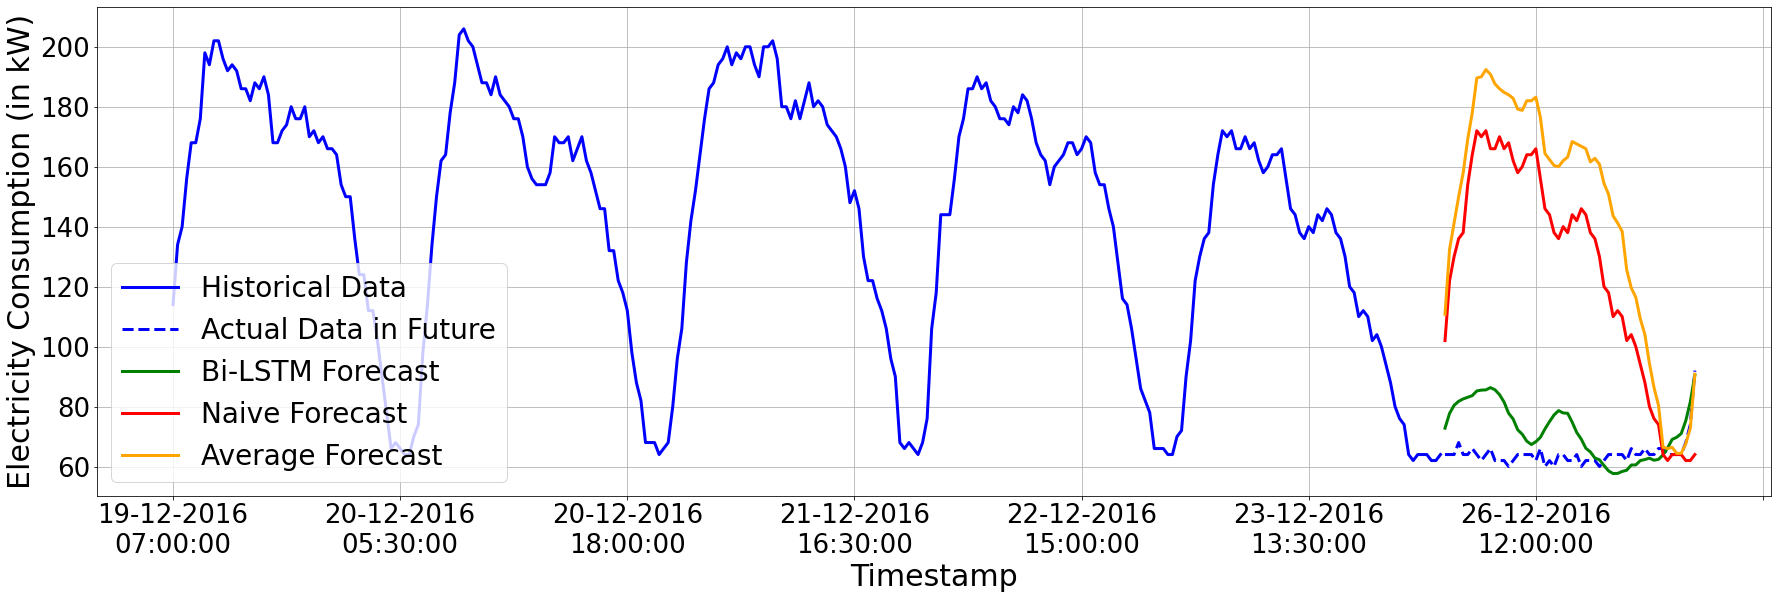

In [ ]:
testWindowNumberToPlot = 21739#953

formatter = MyFormatter(np.append(dateTestX[testWindowNumberToPlot], dateTestY[testWindowNumberToPlot]))
fig, ax = plt.subplots(figsize=(30, 9))
ax.xaxis.set_major_formatter(formatter)
#plt.figure(figsize=(30, 9))
plt.rc('font', size=17)         # controls default text sizes
plt.rc('axes', titlesize=30)    # fontsize of the axes title
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=26)   # fontsize of the tick labels
plt.rc('ytick', labelsize=26)   # fontsize of the tick labels
plt.rc('legend', fontsize=28)   # legend fontsize
plt.rc('figure', titlesize=35)  # fontsize of the figure title
plt.plot(np.append(myTestXTT[testWindowNumberToPlot], np.nan*myTestYTT[testWindowNumberToPlot]), color='blue', marker='', linestyle='-', linewidth=3, markersize=2)
plt.plot(np.append(np.nan*myTestXTT[testWindowNumberToPlot], myTestYTT[testWindowNumberToPlot]), color='blue', marker='', linestyle='--', linewidth=3, markersize=2)
plt.plot(np.append(np.nan*myTestXTT[testWindowNumberToPlot], bilstmForecastTestTT[testWindowNumberToPlot]), color='green', marker='', linestyle='-', linewidth=3, markersize=2)
plt.plot(np.append(np.nan*myTestXTT[testWindowNumberToPlot], naiveForecastTestTT[testWindowNumberToPlot]), color='red', marker='', linestyle='-', linewidth=3, markersize=2)
plt.plot(np.append(np.nan*myTestXTT[testWindowNumberToPlot], averageForecastTestTT[testWindowNumberToPlot]), color='orange', marker='', linestyle='-', linewidth=3, markersize=2)
plt.xlabel("Timestamp", fontsize=30)
plt.ylabel("Electricity Consumption (in kW)", fontsize=30)
plt.legend(("Historical Data", "Actual Data in Future","Bi-LSTM Forecast","Naive Forecast","Average Forecast"), fontsize=28)
plt.grid(True)
#fig.autofmt_xdate()
#plt.savefig("/content/drive/My Drive/Colab Notebooks/Electricity Forecasting/ForecastingResults2.pdf", bbox_inches = 'tight', pad_inches = 0.05)
#plt.close()